<a href="https://colab.research.google.com/github/jehee-lee/jjtech/blob/main/mnist_model_LNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 사이트

mnist 카메라



pytorch zero to all:
https://www.youtube.com/watch?v=lvNdl7yg4Pg&list=PLlMkM4tgfjnJ3I-dbhO9JTw7gNty6o_2m&index=9

pytorch로 시작하는 딥 러닝 입문
https://wikidocs.net/60324

모델 저장 및 불러오기

https://justkode.kr/deep-learning/pytorch-save

https://velog.io/@nawnoes/pytorch-%EB%AA%A8%EB%8D%B8-%EC%A0%80%EC%9E%A5-%EB%B0%8F-%EB%B6%88%EB%9F%AC%EC%98%A4%EA%B8%B0

https://justkode.kr/deep-learning/pytorch-save

구현할 기능

1. mnist데이터셋을 불러오기
2. 학습용 모델 구현하기 (NLL모델)
3. 학습 진행하기
4. 학습, 검증 중 측정된 loss와 accuracy를 확인하기
5. 학습된 분류모델을 이용해 임의의 데이터 분류하기
6. 학습된 모델을 외부 경로에 저장하기

cuda 활용 여부 확인 (코랩에서는 cuda로 실행)

In [ ]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Training MNIST Model on {device}\n{"=" * 44}')

mnist 학습용 데이터셋과 테스트용 데이터셋 불러오기

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
train_dset = dsets.MNIST(root='/content/drive/MyDrive/opencvRo',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)
test_dset = dsets.MNIST(root='/content/drive/MyDrive/opencvRo',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

배치사이즈를 입력하고 train_loader와 test_loader변수에 데이터 입력

In [ ]:
batch_size =64

train_loader = DataLoader(dataset=train_dset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

test_loader = DataLoader(dataset=test_dset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

모델 생성

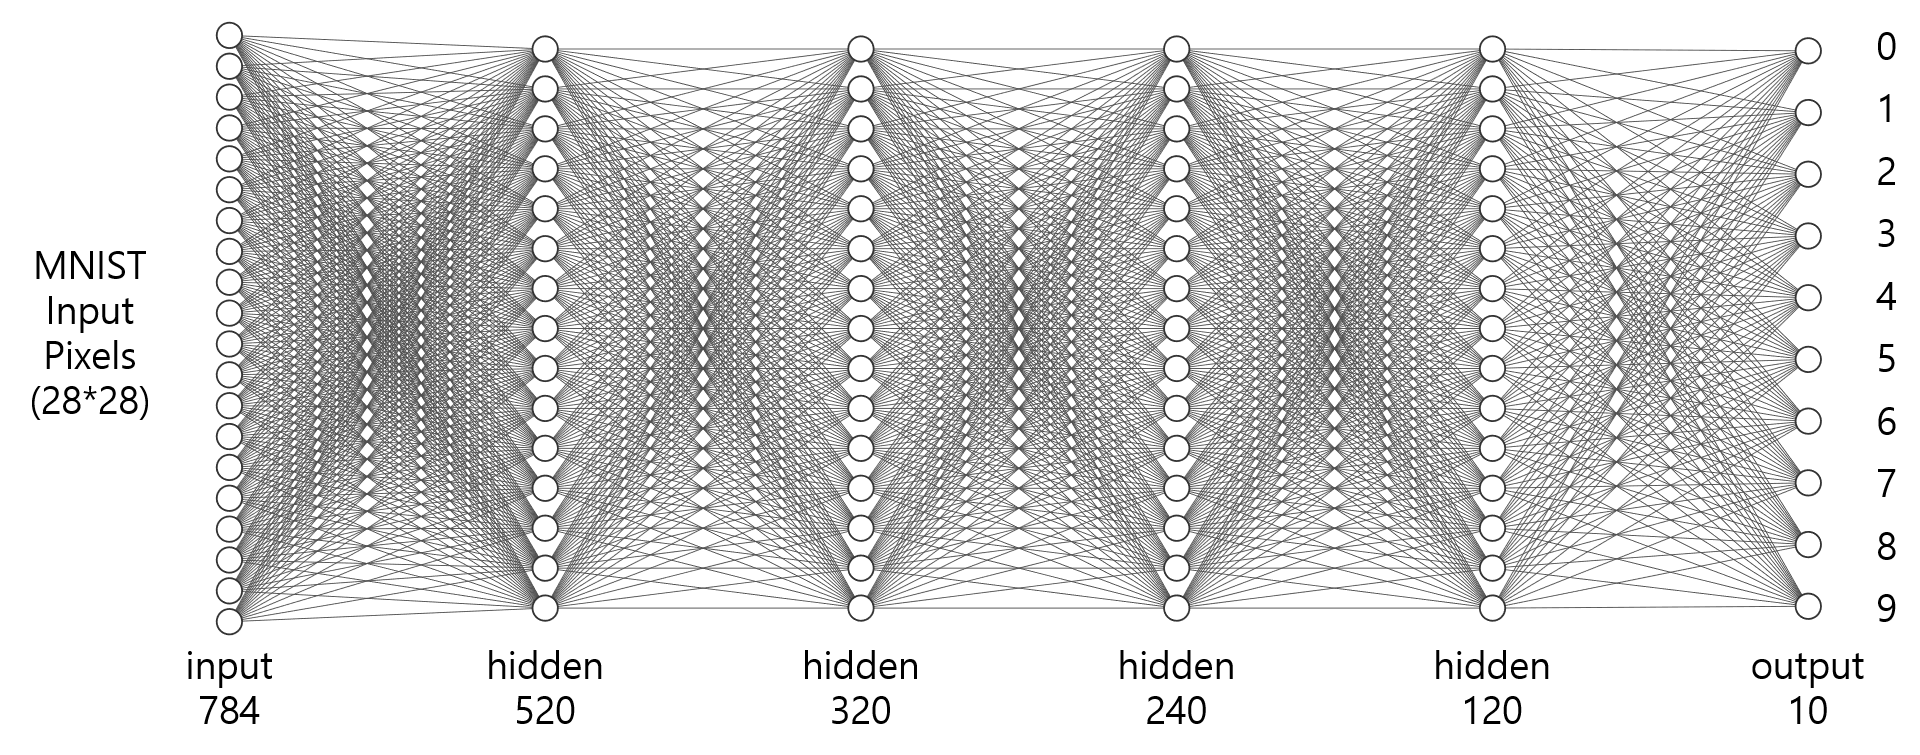



CNN 생성

비용함수: 크로스엔트로피 함수

옵티마이저: 모델=SGD, 학습율=0.01, 모멘텀=0.5

In [3]:
from torch import nn, optim
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 520)
        self.l2 = nn.Linear(520, 320)
        self.l3 = nn.Linear(320, 240)
        self.l4 = nn.Linear(240, 120)
        self.l5 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)

model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

loss, accuracy 경향 분석을 위한 plot 데이터 추가

In [ ]:
import matplotlib.pyplot as plt

loss_list=[]
acc_list = []

학습 함수 정의


In [ ]:
def train(epoch):
  model.train()
  for batch_idx, (X,Y) in enumerate(train_loader):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    output=model(X)
    loss = criterion(output, Y)
    loss_list.append(loss.item())#loss 수집
    loss.backward()
    optimizer.step()
    if batch_idx %10==0:
      print('Train Epoch: {} | Batch Status : {}/{}({:.0f}%) | Loss: {:.6f}'
      .format(epoch, batch_idx*len(X), len(train_loader.dataset),
              100.*batch_idx / len(train_loader), loss.item()))

테스트 함수 정의

In [ ]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  for X, Y in test_loader:
    X, Y = X.to(device), Y.to(device)
    output = model(X)
    test_loss += criterion(output, Y).item()
    pred = output.data.max(1,keepdim=True)[1]
    correct += pred.eq(Y.data.view_as(pred)).cpu().sum()
    test_loss /= len(test_loader.dataset)
    Accuracy = 100. * correct / len(test_loader.dataset)
    acc_list.append(Accuracy.item())#Accuracy 수집
    print(f'===========================\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({Accuracy:.0f}%)')

최종적으로 함수를 실행 (time 패키지를 통해 학습 시간 측정)

In [ ]:
import time

if __name__ == '__main__':
    since = time.time()
    for epoch in range(1, 10):
        epoch_start = time.time()
        train(epoch)
        m, s = divmod(time.time() - epoch_start, 60)
        print(f'Training time: {m:.0f}m {s:.0f}s')
        test()
        m, s = divmod(time.time() - epoch_start, 60)
        print(f'Testing time: {m:.0f}m {s:.0f}s')

    m, s = divmod(time.time() - since, 60)
    print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')

Loss, Accuracy 출력

In [5]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print()

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
l1.weight 	 torch.Size([520, 784])
l1.bias 	 torch.Size([520])
l2.weight 	 torch.Size([320, 520])
l2.bias 	 torch.Size([320])
l3.weight 	 torch.Size([240, 320])
l3.bias 	 torch.Size([240])
l4.weight 	 torch.Size([120, 240])
l4.bias 	 torch.Size([120])
l5.weight 	 torch.Size([10, 120])
l5.bias 	 torch.Size([10])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.5, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


In [ ]:
plt.plot(loss_list)

In [ ]:
plt.plot(acc_list)

모델 테스트 1) 최종 accuracy 구하기

In [ ]:
with torch.no_grad(): #gradient 계산 비활성화
  #테스트 함수 불러오기(data와 label을 각각 X_test, Y_test에 불러옴)
  X_test = test_dset.test_data.view(-1,28*28).float().to(device)
  Y_test = test_dset.test_labels.to(device)

  #정확도 예측
  predict = model(X_test) #학습된 모델에 X_test 입력
  correct_prediction = torch.argmax(predict, 1) == Y_test
  final_acc = correct_prediction.float().mean()
  print('Accuracy:', final_acc.item())

모델 테스트 2) 분류모델을 활용해 임의의 데이터 분류하기

Label: 7
Prediction: 7


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


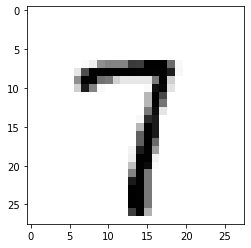

In [ ]:
import random
r = random.randint(0, len(test_dset)-1) #숫자 r은 test데이터셋의 크기만큼의 숫자중 하나
X_val = test_dset.test_data[r:r+1].view(-1,28*28).float().to(device)
Y_val = test_dset.test_labels[r:r+1].to(device)

print('Label:', Y_val.item())
single_prediction = model(X_val)
print('Prediction:', torch.argmax(single_prediction,1).item())

plt.imshow(test_dset.test_data[r:r+1].view(28,28), cmap='Greys')
plt.show()

모델 저장하기 (LNN)

모델의 매개변수 저장
모델의 옵티마이저 저장

In [ ]:
PATH = '/content/drive/MyDrive/opencvRo/'

torch.save(model.state_dict(), PATH +'model_for_RO_LNN.pt')
torch.save(optimizer.state_dict(),PATH +'optimizer_for_RO_LNN.pt')

모델 저장하기 (CNN)

모델 불러오기 / GPU에서 저장하고 CPU에서 불러오기

https://tutorials.pytorch.kr/beginner/saving_loading_models.html

모델 불러오는 방법은 아래와 같음

모델 만들기

모델의 매개변수 불러오기

In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 520)
        self.l2 = nn.Linear(520, 320)
        self.l3 = nn.Linear(320, 240)
        self.l4 = nn.Linear(240, 120)
        self.l5 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)

device = torch.device('cpu')

model = Net()
PATH = '/content/drive/MyDrive/opencvRo/'

model.load_state_dict(torch.load(PATH + 'model_for_RO.pt', map_location=device))

<All keys matched successfully>

임의의 데이터 분류하여 모델 불러오기가 제대로  되었는지 확인

Label: 1
Prediction: 1


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


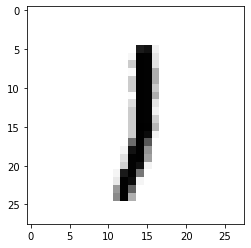

In [ ]:
import random

import matplotlib.pyplot as plt

r = random.randint(0, len(test_dset)-1) #숫자 r은 test데이터셋의 크기만큼의 숫자중 하나
X_val = test_dset.test_data[r:r+1].view(-1,28*28).float().to(device)
Y_val = test_dset.test_labels[r:r+1].to(device)

print('Label:', Y_val.item())
single_prediction = model(X_val)
print('Prediction:', torch.argmax(single_prediction,1).item())

plt.imshow(test_dset.test_data[r:r+1].view(28,28))
plt.imshow(test_dset.test_data[r:r+1].view(28,28),cmap='Greys')
plt.show()

=========================추론하기================================


mnist가 아닌, 숫자 파일을 인식할 수 있는지 확인

1) openCV를 이용해 사진 가져와서 확인하기

In [ ]:
import cv2
 

img = cv2.imread('/content/drive/MyDrive/opencvRo/number/0.png')

plt.imshow(img)
plt.axis('off')
plt.show()

사진 사이즈 변경

사이즈가 변경된 사진을 넘파이로 변경



In [ ]:
img_resize = cv2.resize(img, (28,28))

plt.imshow(img_resize)
plt.show()


이미지를 텐서로 변환 (참고만)

https://www.youtube.com/watch?v=8PnxJ3s3Cwo

https://truman.tistory.com/215



In [7]:
'''
참고만 할 것
import torchvision.transforms as transforms
import torchvision.datasets as dsets

trans = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()])
Val = dsets.ImageFolder(root='/content/drive/MyDrive/opencvRo/dd', transform=trans)
...

SyntaxError: ignored

cv2에서 불러온 이미지를 텐서로 변환

이 때 불러온 이미지는 사이즈가 정해져있지 않으며, 3채널(r,g,b)형태임

(208, 206, 3)


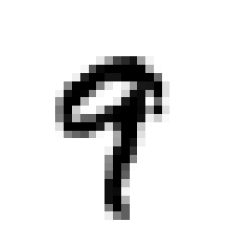

In [ ]:
import cv2
 

img = cv2.imread('/content/drive/MyDrive/opencvRo/number/9.png')

print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

cv2.resize를 통해 사이즈를 조정하고

cv2.imread를 통해 이미지를 1채널(grayscale)로 변환

이 때 mnist로 만들어진 이미지는 흑백이 반전되어있기 때문에 흑백 반전을 실행한다.
 (mnist에서는 cmap='Greys'일 때, 외부 사진에선 cmap ='gray'일 때 원하는 값이 나옴)

만들어진 데이터를 pytorch 명령어를 통해 텐서형으로 변환


shape of img1: (28, 28, 3)


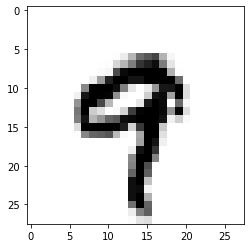

shape of img2: (28, 28)


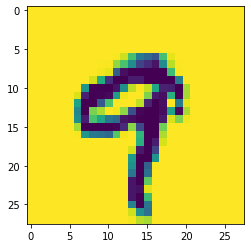

shape of img3: (28, 28)


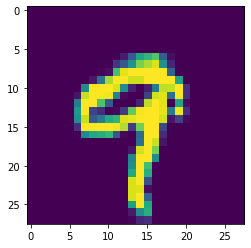

shape of img4: torch.Size([28, 28])


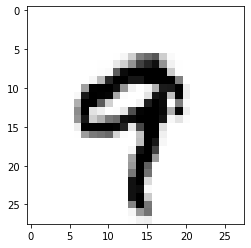

In [ ]:
import numpy as np

#28*28로 리사이즈
img1 = cv2.resize(img, (28,28))

print("shape of img1:", img1.shape)
plt.imshow(img1)
plt.show()

#그레이스케일로 변환
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

print("shape of img2:", img2.shape)

plt.imshow(img2)
plt.show()

#출력된 색상이 학습된 이미지의 색상과 반전되어있으므로 반전 실행
img3 = ~img2

print("shape of img3:", img3.shape)

plt.imshow(img3)
plt.show()

#파이토치 명령어를 통해 이미지(openCV의 경우 numpy형)를 텐서형으로 변환 후 그레이스케일로 출력
img_fin = torch.from_numpy(img3)

print("shape of img4:", img_fin.shape)

plt.imshow(img_fin.view(28,28),cmap='Greys')
plt.show()

최종적으로 이미지가 분류되는지 확인

Prediction: 9


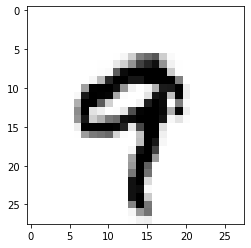

In [ ]:
result = img_fin.view(-1,28*28).float().to(device)

single_prediction = model(result)
print('Prediction:', torch.argmax(single_prediction,1).item())

plt.imshow(img_fin.view(28,28))
plt.imshow(img_fin.view(28,28),cmap='Greys')
plt.show()